# Assignment 1: Prediction of Airline passengers

**Learning Team 3**
- Francis Mark M. Cayco
- Eros Paul V. Estante
- Andrel Heber M. Jison
- Angela Elaine F. Pelayo

**Masters of Science in Data Science**

COSCI222_0 - Machine Learning 2 


Consider the international airline passengers data from January 1949 to December 1960 here: https://www.kaggle.com/datasets/andreazzini/international-airline-passengers


(1) Forecast using ARIMA the last twelve months (1 year, January-December 1960) with the most optimal choice of p,d,q [10 pts]

(2) Compare the results' RMSE, MAE, and run time with optimal XGBoost. [10 pts]



In [350]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.metrics import mean_absolute_error
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
import itertools

LAGS = 12

## Statistics

In [351]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(original_series, diff_series, interval=1):
    original_series = original_series.to_list()
    diff_series = diff_series.copy()
    inverted_series = []
    for i in range(len(diff_series)):
        value = diff_series[i] + original_series[i - interval] 
        inverted_series.append(value)
    return pd.Series(inverted_series)


In [352]:
df = pd.read_csv('assets/international-airline-passengers.csv')
df.columns = ['Date','Passengers']

df['Passengers_Diff'] = pd.Series(difference(df['Passengers'], LAGS))

df.dropna(subset='Passengers',axis=0, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df_train = df[df['Date'] < '1960-01-01']
df_test = df[df['Date'] >= '1960-01-01']

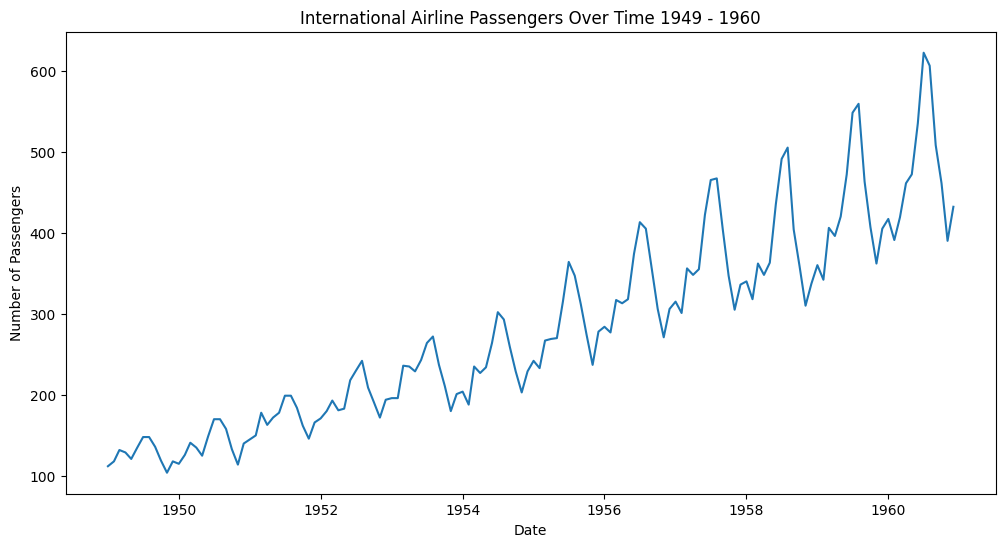

In [353]:
# Plot the data with Date on the x-axis and Passengers on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Passengers'])
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('International Airline Passengers Over Time 1949 - 1960')
plt.show()

Observations:

1. Trend - Shows an upward trend over time, indicating that the number of airline passengers has been increasing steadily.
2. Seasonality - repeating seasonal pattern, with peaks and troughs occurring at yearly intervals.
3. Stationarity - The data is non-stationary, as the mean and variance change over time.

### Seasonal Line Plot

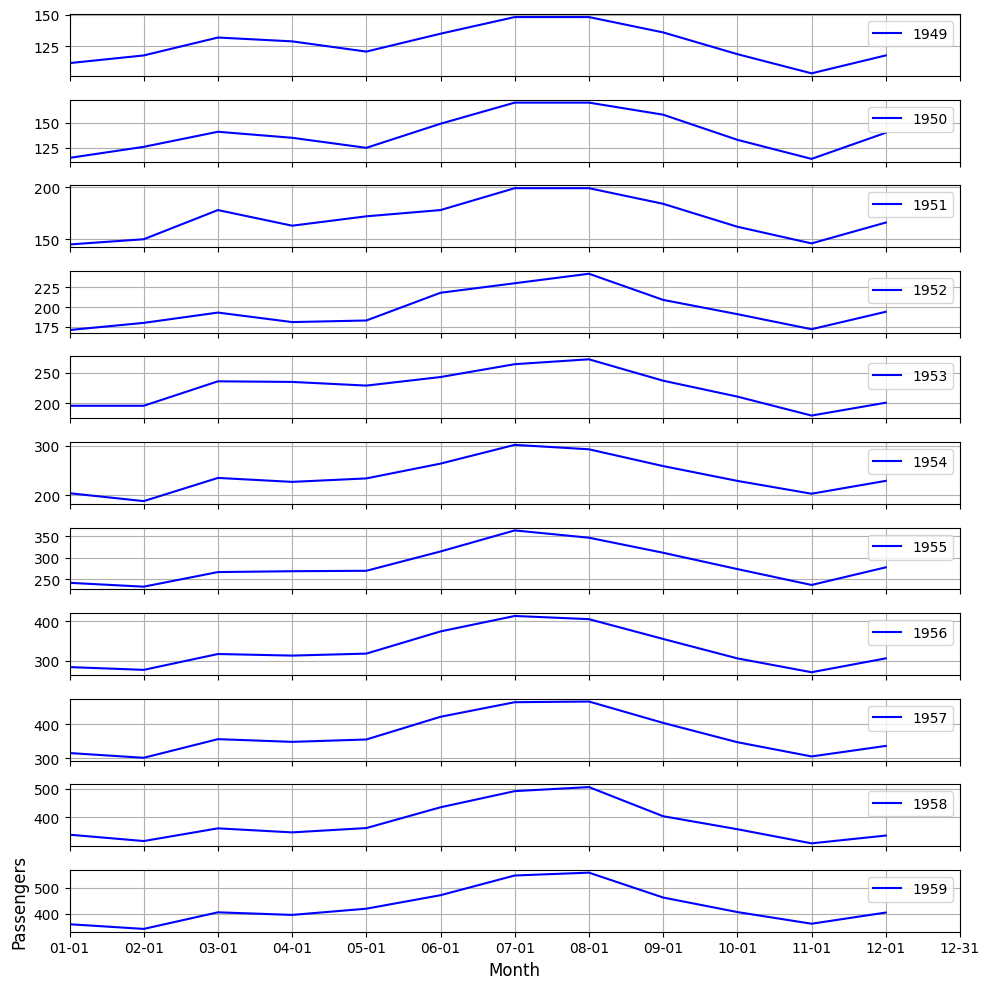

In [354]:
# Set the 'Date' column as index
df_train.set_index('Date', inplace=True)

# Group the training data by year ('A' stands for annual frequency)
groups = df_train.groupby(pd.Grouper(freq='YE'))

# Initialize the plotting area, making sure to accommodate each group
fig, axs = plt.subplots(len(groups), 1, figsize=(10, 10), sharex=True)

# Loop over each group to plot separately
for i, (name, group) in enumerate(groups):
    # Format index to show only the month and day for alignment
    group.index = group.index.strftime('%m-%d')
    
    axs[i].plot(group.index, group['Passengers'], label=f'{name.year}', color='b')
    axs[i].set_xlim(['01-01', '12-31'])  # Set x-axis from January to December
    axs[i].legend(loc='upper right')  # Use the legend to show the year
    axs[i].grid(True)  # Add grid for better visual clarity

# Set common x and y labels
plt.xlabel('Month', fontsize=12)
plt.ylabel('Passengers', fontsize=12)

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()

# Show the plot
plt.show()

Observation

- Seasonality: Similar pattern is observed where peaks usually happens in July & August, and troughs happening in November, and February


- Year-to-Year Consistency: This pattern appears similarly almost every year. While the absolute number of passengers increases over the years, the relative seasonal behavior remains steady, reinforcing the reliability of this pattern for forecasting.

### Density Plot

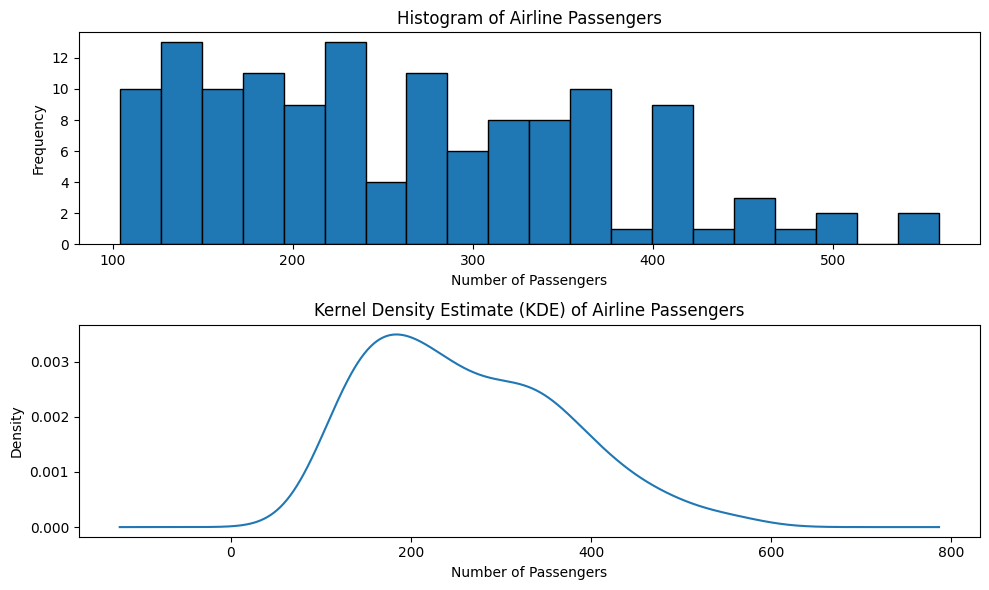

In [355]:
import matplotlib.pyplot as plt

# Extract the 'Passengers' column from the training dataset
series = df_train['Passengers']

# Create the figure for subplots with appropriate size
plt.figure(figsize=(10, 6))

# Create the histogram in the first subplot
plt.subplot(2, 1, 1)
plt.hist(series, bins=20, edgecolor='black')
plt.title('Histogram of Airline Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')

# Create the kernel density estimate (KDE) plot in the second subplot
plt.subplot(2, 1, 2)
series.plot(kind='kde')
plt.title('Kernel Density Estimate (KDE) of Airline Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Observations 

1. Non-Gaussian Distribution - The histogram shows a skewed shape rather than a symmetric bell curve
2. Distribution Shape - The distribution of airline passengers is right-skewed, meaning that most observations are on the lower side with a long tail extending to the right.

### Box and Whisker Plot

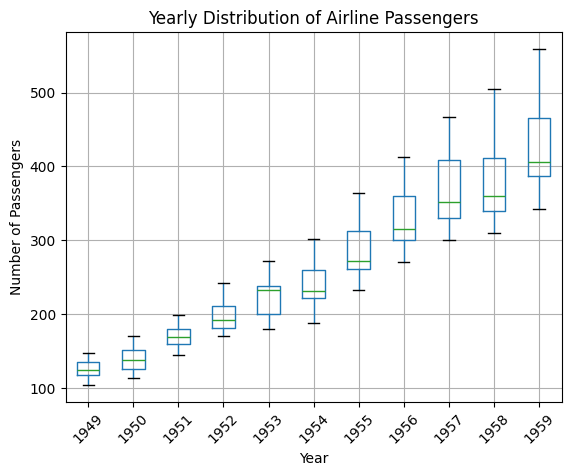

In [356]:
import pandas as pd
import matplotlib.pyplot as plt

series = df_train['Passengers']

# Group the series data by year ('A' stands for annual frequency)
groups = series['1949':'1959'].groupby(pd.Grouper(freq='YE'))

# Create an empty DataFrame to store yearly data
years = pd.DataFrame()

# Loop through each group and store the values in the 'years' DataFrame
for name, group in groups:
    years[name.year] = group.values

# Plot a boxplot for each year
years.boxplot()

# Show the plot
plt.title('Yearly Distribution of Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Observations

1. Median (Green Line) - increases steadily over time. This indicates consistent growth of passengers over time.
2. Spread (Blue Boxes) - size of boxes increases over time, indicating increasing variability - higher flunctuations over time. 
3. Outliers - no significant outliers, indicating stable and reliable data trends.

### Overall Observations

- Trend: Passenger numbers show a consistent upward trajectory from 1949 to 1959, indicating a strong long-term growth component.
- Seasonality: Clear annual patterns with recurring peaks suggest the presence of seasonal trends, making seasonal adjustments crucial.
- Variability: The increasing spread in passenger numbers over time highlights growing fluctuations that ARIMA models need to accommodate.
- Stationarity Consideration: The upward trend and seasonal effects suggest the need for differencing to achieve stationarity before modeling.


## Stationary Test for Seasonal Lag Differencing

## Hypotheses in the ADF Test

### Null Hypothesis $  H_0 \ $

- The time series **has a unit root**, meaning it is **non-stationary**, i.e., it has some time-dependent structure.
- If the null hypothesis cannot be rejected, the series is likely **non-stationary**.

### Alternative Hypothesis $  H_1  $

- The time series **does not have a unit root**, meaning it is **stationary**.

## Interpreting the ADF Test Results

### If the p-value > 0.05:
- **Fail to reject the null hypothesis  $ H_0 $ .**
- The series is **non-stationary**, meaning further differencing or transformations may be needed.

### If the p-value ≤ 0.05:
- **Reject the null hypothesis $ H_0 $ in favor of the alternative $ H_1 $.**
- The series is **stationary**, meaning no further differencing is needed.


In [357]:
# Perform the ADF test to check stationarity
# Ensure df['Passengers'] is converted to a list or numpy array for indexing
stationary_series = difference(df['Passengers'].values, LAGS)

# Perform the ADF test
result = adfuller(stationary_series)

# Print the ADF test results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.383021
p-value: 0.011551
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


- Since the p-value (0.011551) is less than 0.05, we reject the null hypothesis meaning that the time series is stationary after applying seasonal differencing with a lag of 12 months.

- Additionally, the ADF statistic (-3.383021) is lower (more negative) than the 5% critical value (-2.884), further supporting the conclusion that the series does not contain a unit root and is stationary.


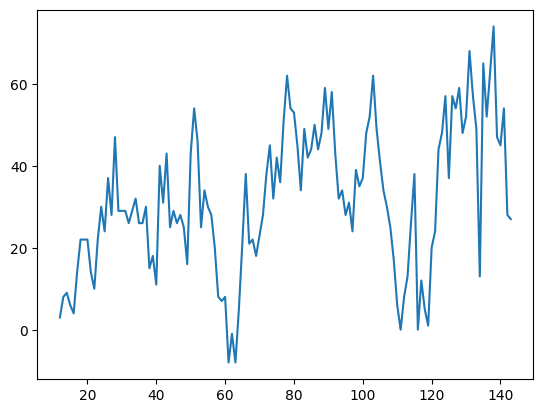

In [358]:
# Convert the series values to float32
X = df['Passengers'].values
X = X.astype('float32')

# Difference data with a lag of 12 months
# months_in_year = 12
stationary = difference(X, LAGS)

# Set the index of the stationary series to align with the original series
stationary.index = df.index[LAGS:]

# Plot the differenced data
stationary.plot()
#plt.grid()
plt.show()

## Forecasting Using ARIMA

In [359]:
p_values = range(0, 8)
d_values = range(0, 2)
q_values = range(0, 8)

In [360]:
model = []
rmse = []
forecasts = []
times = []
mse = []
for p, d, q, in product(p_values, d_values, q_values):
    time_ = time.time()
    arima = ARIMA(df_train['Passengers_Diff'], order=(p,d,q), enforce_stationarity=True, dates=df_train.index)
    arima_fit = arima.fit()
    forecast = arima_fit.get_forecast(steps=len(df_test))
    forecast_values = forecast.predicted_mean.values
    forecast_values = inverse_difference(df_train['Passengers'],forecast_values,len(df_test))
    # display(test)
    forecasts.append(forecast_values)
    model.append((p, d, q))
    rmse.append(root_mean_squared_error(df_test['Passengers'], forecast_values))
    mse.append(mean_squared_error(df_test['Passengers'], forecast_values))
    times.append(time.time() - time_)


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No fr

In [361]:
results = pd.DataFrame({'ARIMA(p,d,q)': model, 'RMSE': rmse, 'Time': times, 'MSE':mse}).sort_values('RMSE')
results.head(10)

,"ARIMA(p,d,q)",RMSE,Time,MSE
46,"(2, 1, 6)",19.152230,0.137153,366.807920
45,"(2, 1, 5)",19.400993,0.110185,376.398537
63,"(3, 1, 7)",20.572509,0.201898,423.228115
12,"(0, 1, 4)",20.869945,0.016011,435.554603
79,"(4, 1, 7)",21.323730,0.293649,454.701465
122,"(7, 1, 2)",21.347450,0.127908,455.713638
15,"(0, 1, 7)",21.405850,0.065068,458.210420
62,"(3, 1, 6)",21.469318,0.163606,460.931613
14,"(0, 1, 6)",21.502120,0.039402,462.341152
29,"(1, 1, 5)",21.602356,0.066772,466.661774


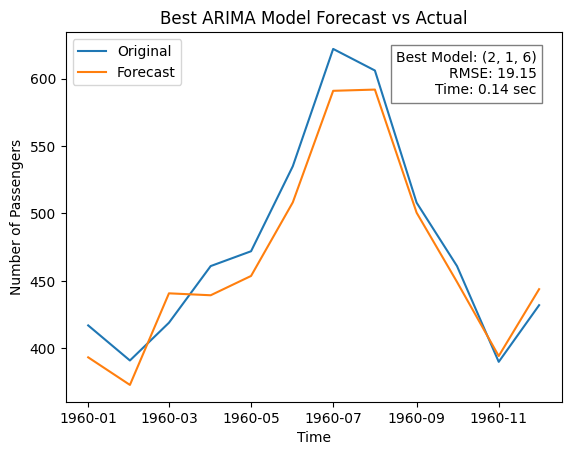

In [362]:
best_model = model[np.argmin(rmse)]
best_rmse = np.min(rmse)

plt.plot(df_test['Date'], df_test['Passengers'], label='Original')
plt.plot(df_test['Date'], forecasts[np.argmin(rmse)], label='Forecast')
plt.title('Best ARIMA Model Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.text(0.95, 0.95, f'Best Model: {best_model}\nRMSE: {best_rmse:.2f}\nTime: {times[np.argmin(rmse)]:.2f} sec', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()


## Forecasting using XGBoost

### First Method: Create Lagged Features
1. Generate lagged features (`T-12`, `T-11`, ..., `T-1`) as input columns.
2. Use the current month's passenger count as the `Target`.

### Second Method: Add Temporal Features
1. Extract `Year`, `Month`, and `Quarter` from the `Date` column.
2. Use these features as inputs alongside the `Target`.

In [363]:
def create_lagged_features(data, lags, target_col):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f"T-{lag}"] = df[target_col].shift(lag)
    return df

In [364]:
df = pd.read_csv('assets/international-airline-passengers.csv')
df.columns = ['Date','Passengers']
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m", errors="coerce")
df = df.dropna()  # Remove rows with invalid or missing dates


In [365]:
df_lagged = create_lagged_features(df, LAGS, target_col="Passengers")
first_method = df_lagged[
    [f"T-{i}" for i in range(LAGS, 0, -1)] + ["Passengers"]
].rename(columns={"Passengers": "Target"})

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Quarter"] = (df["Month"] - 1) // 3 + 1

second_method = df[["Year", "Month", "Quarter", "Passengers"]].rename(
    columns={"Passengers": "Target"}
)

In [366]:
df_lagged


,Date,Passengers,T-1,T-2,T-3,T-4,T-5,T-6,T-7,T-8,T-9,T-10,T-11,T-12
0,1949-01-01,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-01,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-01,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-01,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0
140,1960-09-01,508.0,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0
141,1960-10-01,461.0,508.0,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0
142,1960-11-01,390.0,461.0,508.0,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0


### Objective:
1. For the **First Method**, use lagged features to predict the next 12 months.
2. For the **Second Method**, use temporal features (`Year`, `Month`, `Quarter`) to predict the next 12 months.

### Approach:
- Use data before the last 12 months as the training set.
- Use the last 12 months as the testing set for evaluation.

In [367]:
X_first = first_method.drop(columns=["Target"])
y_first = first_method["Target"]

X_train_first = X_first.iloc[:-12]
y_train_first = y_first.iloc[:-12]

X_test_first = X_first.iloc[-12:]
y_test_first = y_first.iloc[-12:]

X_second = second_method.drop(columns=["Target"])
y_second = second_method["Target"]

X_train_second = X_second.iloc[:-LAGS]
y_train_second = y_second.iloc[:-LAGS]

X_test_second = X_second.iloc[-LAGS:]
y_test_second = y_second.iloc[-LAGS:]

print("First Method Training Set:")
print(X_train_first.shape, y_train_first.shape)
print("First Method Testing Set:")
print(X_test_first.shape, y_test_first.shape)

print("\nSecond Method Training Set:")
print(X_train_second.shape, y_train_second.shape)
print("Second Method Testing Set:")
print(X_test_second.shape, y_test_second.shape)



First Method Training Set:
(132, 12) (132,)
First Method Testing Set:
(12, 12) (12,)

Second Method Training Set:
(132, 3) (132,)
Second Method Testing Set:
(12, 3) (12,)


### Objective:
1. Train XGBoost models using the training sets for the **First Method** and **Second Method**.
2. Predict the last 12 months and evaluate using RMSE.
3. Visualize the performance by plotting the actual vs. predicted values.

First Method RMSE: 33.927398450514644
Second Method RMSE: 52.371105493809026


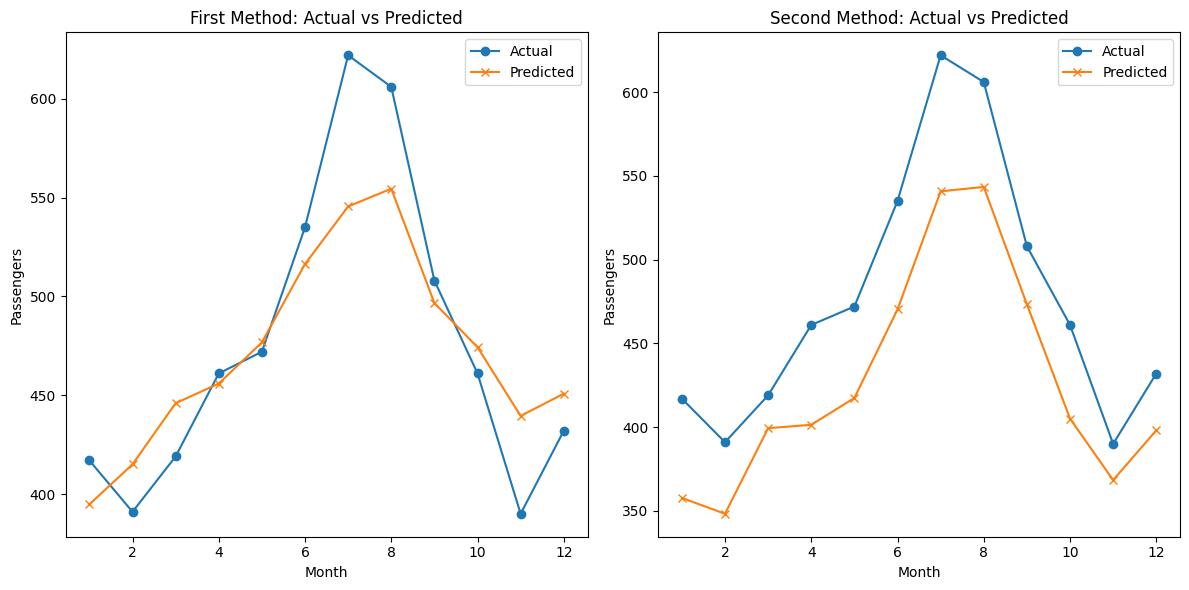

In [368]:
dtrain_first = xgb.DMatrix(X_train_first, label=y_train_first)
dtest_first = xgb.DMatrix(X_test_first, label=y_test_first)

params = {
    "objective": "reg:squarederror",
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}
num_rounds = 100
model_first = xgb.train(params, dtrain_first, num_rounds)

# Predict for the last 12 months
y_pred_first = model_first.predict(dtest_first)

# Calculate RMSE
rmse_first = np.sqrt(mean_squared_error(y_test_first, y_pred_first))
print(f"First Method RMSE: {rmse_first}")

# Train and evaluate for the Second Method
dtrain_second = xgb.DMatrix(X_train_second, label=y_train_second)
dtest_second = xgb.DMatrix(X_test_second, label=y_test_second)

model_second = xgb.train(params, dtrain_second, num_rounds)
y_pred_second = model_second.predict(dtest_second)
rmse_second = np.sqrt(mean_squared_error(y_test_second, y_pred_second))
print(f"Second Method RMSE: {rmse_second}")

# Plot results
plt.figure(figsize=(12, 6))

# First Method Predictions
plt.subplot(1, 2, 1)
plt.plot(range(1, 13), y_test_first.values, label="Actual", marker="o")
plt.plot(range(1, 13), y_pred_first, label="Predicted", marker="x")
plt.title("First Method: Actual vs Predicted")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()

# Second Method Predictions
plt.subplot(1, 2, 2)
plt.plot(range(1, 13), y_test_second.values, label="Actual", marker="o")
plt.plot(range(1, 13), y_pred_second, label="Predicted", marker="x")
plt.title("Second Method: Actual vs Predicted")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()

plt.tight_layout()
plt.show()



### Hyperparameter Tuning

1. Optimize the hyperparameters of the XGBoost model for the **First Method**. We skip the hyperparameter tuning for the **Second Method** since the RMSE for the First Method is already low compared to the Second Method.
2. Evaluate the optimized model's performance.

### Approach:
- Manually iterate over a range of hyperparameters.
- Evaluate the RMSE for each combination.
- Select the combination with the lowest RMSE.

In [369]:
params = []
rmse = []
forecasts = []
times = []
mse = []

In [370]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

param_combinations = list(itertools.product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["n_estimators"],
    param_grid["subsample"],
    param_grid["colsample_bytree"]
))

for max_depth, learning_rate, n_estimators, subsample, colsample_bytree in param_combinations:
    time_ = time.time()
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        seed=42
    )
    
    model.fit(X_train_first, y_train_first)
    y_pred = model.predict(X_test_first)
    
    params.append({
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
    })
    rmse.append(np.sqrt(mean_squared_error(y_test_first, y_pred)))
    forecasts.append(y_pred)
    times.append(time.time() - time_)
    mse.append(mean_squared_error(y_test_first, y_pred))


In [371]:
results = pd.DataFrame({'XGB Params': params, 'RMSE': rmse, 'Time': times, 'MSE':mse}).sort_values('RMSE')
results.head(10)

,XGB Params,RMSE,Time,MSE
238,"{'max_depth': 7, 'learning_rate': 0.1, 'n_esti...",33.034184,0.107059,1091.257329
239,"{'max_depth': 7, 'learning_rate': 0.1, 'n_esti...",33.299823,0.127833,1108.878227
241,"{'max_depth': 7, 'learning_rate': 0.1, 'n_esti...",33.480200,0.091036,1120.923771
131,"{'max_depth': 5, 'learning_rate': 0.05, 'n_est...",33.563913,0.091754,1126.536224
154,"{'max_depth': 5, 'learning_rate': 0.1, 'n_esti...",33.582706,0.075526,1127.798136
229,"{'max_depth': 7, 'learning_rate': 0.1, 'n_esti...",33.611360,0.048244,1129.723492
157,"{'max_depth': 5, 'learning_rate': 0.1, 'n_esti...",33.718882,0.093588,1136.963016
232,"{'max_depth': 7, 'learning_rate': 0.1, 'n_esti...",33.748039,0.049959,1138.930131
212,"{'max_depth': 7, 'learning_rate': 0.05, 'n_est...",33.921321,0.107620,1150.656049
148,"{'max_depth': 5, 'learning_rate': 0.1, 'n_esti...",33.927398,0.044799,1151.068366


Best Model
{'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8}


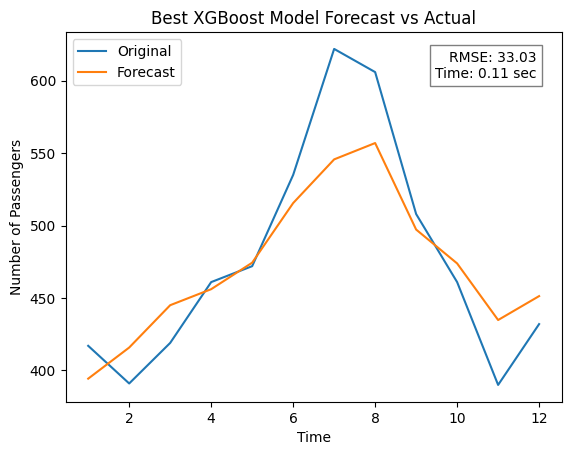

In [372]:
best_model = params[np.argmin(rmse)]
best_rmse = np.min(rmse)

plt.plot(range(1, 13), y_test_first.values, label='Original')
plt.plot(range(1, 13), forecasts[np.argmin(rmse)], label='Forecast')
plt.title('Best XGBoost Model Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.text(0.95, 0.95, f'RMSE: {best_rmse:.2f}\nTime: {times[np.argmin(rmse)]:.2f} sec', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

print("Best Model")
print(best_model)

# Summary and Interpretation of Results

The comparison between ARIMA and XGBoost for the airline passengers dataset revealed clear distinctions in their performances, highlighting the strengths and limitations of each approach. The ARIMA model outperformed XGBoost with a significantly lower RMSE of **19.15** compared to **33.03** for XGBoost, demonstrating its effectiveness in capturing the underlying seasonality and trend inherent in this time series data. The best ARIMA configuration `(2, 1, 6)` successfully modeled the autoregressive (AR), differencing (D), and moving average (MA) components of the dataset, yielding predictions that closely aligned with the actual values.

XGBoost, while a powerful and flexible machine learning algorithm, struggled to match ARIMA's performance in this context. The best-performing XGBoost model, with parameters `{max_depth: 7, learning_rate: 0.1, n_estimators: 200, subsample: 0.8, colsample_bytree: 0.8}`, achieved an RMSE of **33.03**. This relatively higher error can be attributed to the fact that XGBoost treats the problem as a regression task, relying on engineered lagged features. While these lagged features capture some temporal dependencies, they may not fully encapsulate the cyclic seasonal patterns or trend components inherent in the dataset. Moreover, the dataset's small size (144 data points) limited XGBoost's ability to leverage its complexity effectively, leading to a plateau in performance despite extensive hyperparameter tuning.

ARIMA's strength lies in its simplicity and direct modeling of time series characteristics like seasonality and trends. By enforcing stationarity and optimizing its parameters for autoregressive and moving average terms, ARIMA is well-suited for smaller datasets with clear temporal patterns. XGBoost, on the other hand, excels in more complex datasets with additional features or larger sample sizes, where its flexibility and ability to model non-linear relationships come into play. However, in this case, the lack of explicit handling of sequential relationships and seasonal cycles hindered XGBoost's performance.

In terms of computation time, both models demonstrated efficiency, with similar runtimes for their best configurations. While XGBoost generally has an edge in scalability and speed for large datasets, ARIMA's ability to achieve better accuracy with comparable time underscores its suitability for small, structured datasets like this one.
